In [ ]:
# Importera grundläggande bibliotek
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

# Importera scikit-learn moduler
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.preprocessing import MinMaxScaler

# Importera ML-modeller
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 

In [47]:
# Ladda ner MNIST-datan
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [48]:
# Extrahera features (X) och labels (y)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)  # Konvertera labels till integer

## EDA

In [49]:
print(mnist.DESCR)  # Beskriver datasetet

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [50]:
print(f"Formen på X: {mnist.data.shape}")  # Antal rader och kolumner
print(f"Formen på y: {mnist.target.shape}")

Formen på X: (70000, 784)
Formen på y: (70000,)


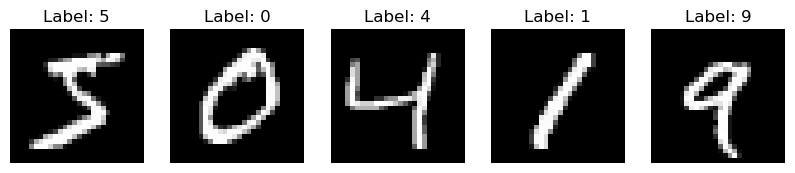

In [51]:
# Plotta några siffror från datasetet
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")

plt.show()

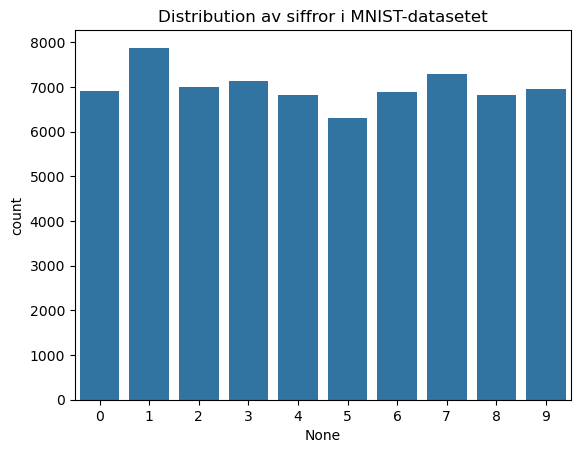

In [52]:
sns.countplot(x=pd.Series(y))  # Ritar en graf över antal förekomster av varje siffra
plt.title("Distribution av siffror i MNIST-datasetet")
plt.show()


In [53]:
print(f"Saknade värden i X: {np.isnan(X).sum()}")
print(f"Saknade värden i y: {np.isnan(y).sum()}")

Saknade värden i X: 0
Saknade värden i y: 0


## Prepering data

In [54]:
# Dela upp 70% träning och 30% temporär data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Dela den temporära datan i 15% validering och 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Kontrollera storleken på datasetet
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (49000, 784), Validation: (10500, 784), Test: (10500, 784)


## Models

In [55]:
# Normalisera endast Random Forests data
X_train_rf = X_train / 255.0
X_val_rf = X_val / 255.0  # Lägg till X_val_rf för validering
X_test_rf = X_test / 255.0

In [56]:
# Skala data för Logistic Regression och SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Lägg till X_val_scaled för validering
X_test_scaled = scaler.transform(X_test)

In [57]:
# Träna Logistic Regression
log_reg = LogisticRegression(max_iter=200, solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200)

In [58]:
# Träna Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=42)

In [59]:
# Träna SVC
svc = SVC(kernel='rbf', C=1.0)
svc.fit(X_train_scaled, y_train)  # Här är det rätt, men använd också X_val_scaled vid utvärdering!

SVC()

In [60]:
# Prediktioner
y_pred_log_reg = log_reg.predict(X_val_scaled)  # Skalad valideringsdata för Logistic Regression
y_pred_rf = rf.predict(X_val_rf)  # Normaliserad valideringsdata för Random Forest
y_pred_svc = svc.predict(X_val_scaled)  # Skalad valideringsdata för SVC

# Utvärdera noggrannhet
acc_log_reg = accuracy_score(y_val, y_pred_log_reg)
acc_rf = accuracy_score(y_val, y_pred_rf)
acc_svc = accuracy_score(y_val, y_pred_svc)

# Skriv ut resultatet
print(f"Logistic Regression Accuracy: {acc_log_reg:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"SVC Accuracy: {acc_svc:.4f}")


Logistic Regression Accuracy: 0.9154
Random Forest Accuracy: 0.9669
SVC Accuracy: 0.9620


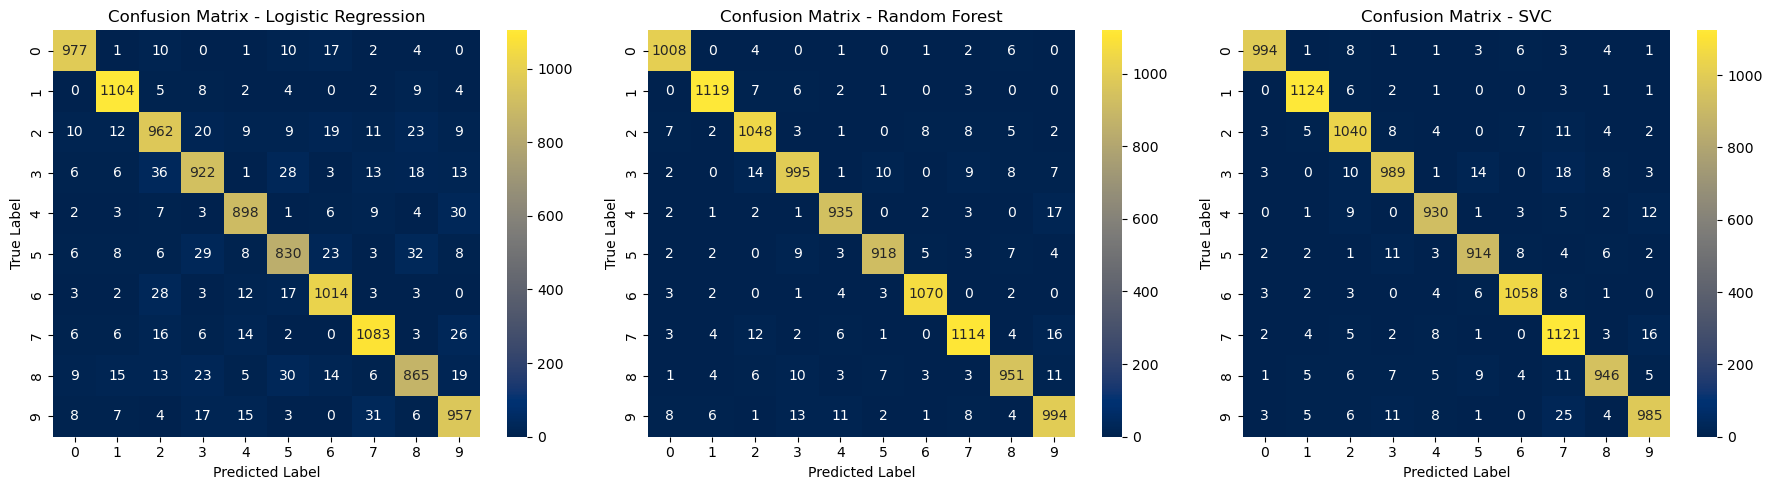

In [61]:
# Plotta Confusion Matrix för alla tre modeller på valideringsdata
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = [("Logistic Regression", y_pred_log_reg, X_val_scaled), 
          ("Random Forest", y_pred_rf, X_val_rf), 
          ("SVC", y_pred_svc, X_val_scaled)]

for i, (model_name, y_pred, X_val_correct) in enumerate(models):
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cividis", ax=axes[i], xticklabels=range(10), yticklabels=range(10))
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_title(f"Confusion Matrix - {model_name}")

plt.tight_layout()  # Förbättrar layouten
plt.show()

# Utvärdera modellen på test-setet

`Random Forest`-modellen var bäst så den får utvärderas på test-datan.

In [62]:
y_pred_best = rf.predict(X_test_rf)  # Använd rätt testdata

In [63]:
# Utvärdera på testdatan
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Bästa modellen på testdatan: {acc_best:.4f}")

Bästa modellen på testdatan: 0.9668


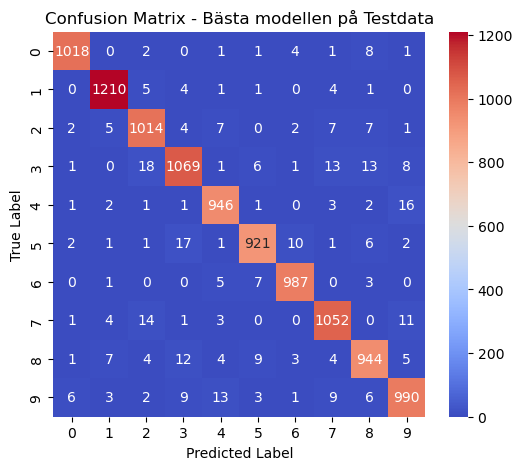

In [64]:
# Plotta Confusion Matrix för bästa modellen på testdatan
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Bästa modellen på Testdata")
plt.show()

In [65]:
import joblib # type: ignore

# Spara modellen
joblib.dump(rf, "best_rf_model.pkl")

['best_rf_model.pkl']